### Clustering - DBSCAN
##### - Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.
##### - Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.
##### - Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

---

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN
# Scaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None,
                  names = ['date', 'time', 'page', 'id', 'cohort', 'ip'])
df

,date,time,page,id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


/var/folders/t2/c4rfp_5j33nfsbfkcj7scwjh0000gn/T/ipykernel_46363/335105209.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['id'])['date', 'page', 'cohort'].nunique().date.hist()


<AxesSubplot:>

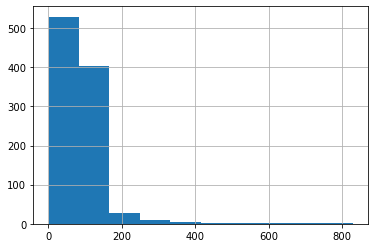

In [3]:
df.groupby(['id'])['date', 'page', 'cohort'].nunique().date.hist()

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [24]:
#df.iloc[:,1:]

In [25]:
scaler = MinMaxScaler().fit(df.groupby(['id'])['page'].agg(['count', 'nunique']))

In [26]:
scaled = scaler.transform(df.groupby(['id'])['page'].agg(['count', 'nunique']))

In [28]:
scaled

array([[4.13298347e-01, 1.00000000e+00],
       [8.59758821e-02, 1.53846154e-01],
       [8.71482805e-02, 1.72307692e-01],
       ...,
       [7.03439035e-03, 1.94871795e-02],
       [1.11656990e-04, 0.00000000e+00],
       [2.28896829e-03, 8.20512821e-03]])

In [30]:
new_df = pd.DataFrame(scaled, columns=[col + '_scaled' for col in df.groupby(['id'])['page'].agg(['count', 'nunique']).columns], index=df.groupby(['id'])['page'].agg(['count', 'nunique']).index)
new_df

,count_scaled,nunique_scaled
id,,
1,0.413298,1.000000
2,0.085976,0.153846
3,0.087148,0.172308
4,0.038577,0.145641
5,0.094908,0.201026
...,...,...
977,0.004745,0.011282
978,0.003015,0.017436
979,0.007034,0.019487


In [32]:
dbsc = DBSCAN(min_samples=20, eps=0.1)
dbsc

DBSCAN(eps=0.1, min_samples=20)

In [33]:
dbsc.fit(new_df)

DBSCAN(eps=0.1, min_samples=20)

In [34]:
new_df.shape

(981, 2)

In [37]:
# Merge the scaled and non-scaled values into one dataframe
all_ = df.groupby(['id'])['page'].agg(['count', 'nunique']).merge(
    new_df, on=df.groupby(['id'])['page'].agg(['count', 'nunique']).index).drop(
    columns=['key_0'])
all_

,count,nunique,count_scaled,nunique_scaled
0,7404,976,0.413298,1.000000
1,1541,151,0.085976,0.153846
2,1562,169,0.087148,0.172308
3,692,143,0.038577,0.145641
4,1701,197,0.094908,0.201026
...,...,...,...,...
976,86,12,0.004745,0.011282
977,55,18,0.003015,0.017436
978,127,20,0.007034,0.019487
979,3,1,0.000112,0.000000


In [38]:
all_['labels'] = dbsc.labels_
all_

,count,nunique,count_scaled,nunique_scaled,labels
0,7404,976,0.413298,1.000000,-1
1,1541,151,0.085976,0.153846,0
2,1562,169,0.087148,0.172308,0
3,692,143,0.038577,0.145641,0
4,1701,197,0.094908,0.201026,0
...,...,...,...,...,...
976,86,12,0.004745,0.011282,0
977,55,18,0.003015,0.017436,0
978,127,20,0.007034,0.019487,0
979,3,1,0.000112,0.000000,0


In [40]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(all_.describe())
print("-------------")
print("Inliers")
print(all_[all_.labels==0].describe())
print("-------------")
print("Outliers")
print(all_[all_.labels==-1].describe())

Population
              count     nunique  count_scaled  nunique_scaled      labels
count    981.000000  981.000000    981.000000      981.000000  981.000000
mean     917.657492  118.356779      0.051176        0.120366   -0.008155
std     1208.871322   80.781117      0.067489        0.082852    0.089982
min        1.000000    1.000000      0.000000        0.000000   -1.000000
25%      187.000000   53.000000      0.010384        0.053333    0.000000
50%      692.000000  140.000000      0.038577        0.142564    0.000000
75%     1297.000000  166.000000      0.072354        0.169231    0.000000
max    17913.000000  976.000000      1.000000        1.000000    0.000000
-------------
Inliers
             count     nunique  count_scaled  nunique_scaled  labels
count   973.000000  973.000000    973.000000      973.000000   973.0
mean    843.253854  115.153135      0.047022        0.117080     0.0
std     787.044042   68.765856      0.043939        0.070529     0.0
min       1.000000    1.0

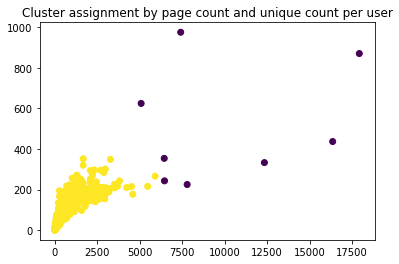

In [41]:
plt.scatter(all_['count'],
           all_['nunique'],
           c=all_['labels'])
plt.title('Cluster assignment by page count and unique count per user')
plt.show()